In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
import tensorflow as tf
from tensorflow import keras
sns.set_style("darkgrid")

2023-09-04 00:10:29.536959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 00:10:29.676140: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-04 00:10:30.264603: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-04 00:10:30.264693: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
# Path for csv files
files_path ='../../raw_data/model_trial/'

# List of files csv
df = pd.read_csv(files_path + 'london_merged.csv',parse_dates=['timestamp'], index_col='timestamp')

In [3]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [4]:
df.shape

(17414, 9)

In [5]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month

<Axes: xlabel='timestamp', ylabel='cnt'>

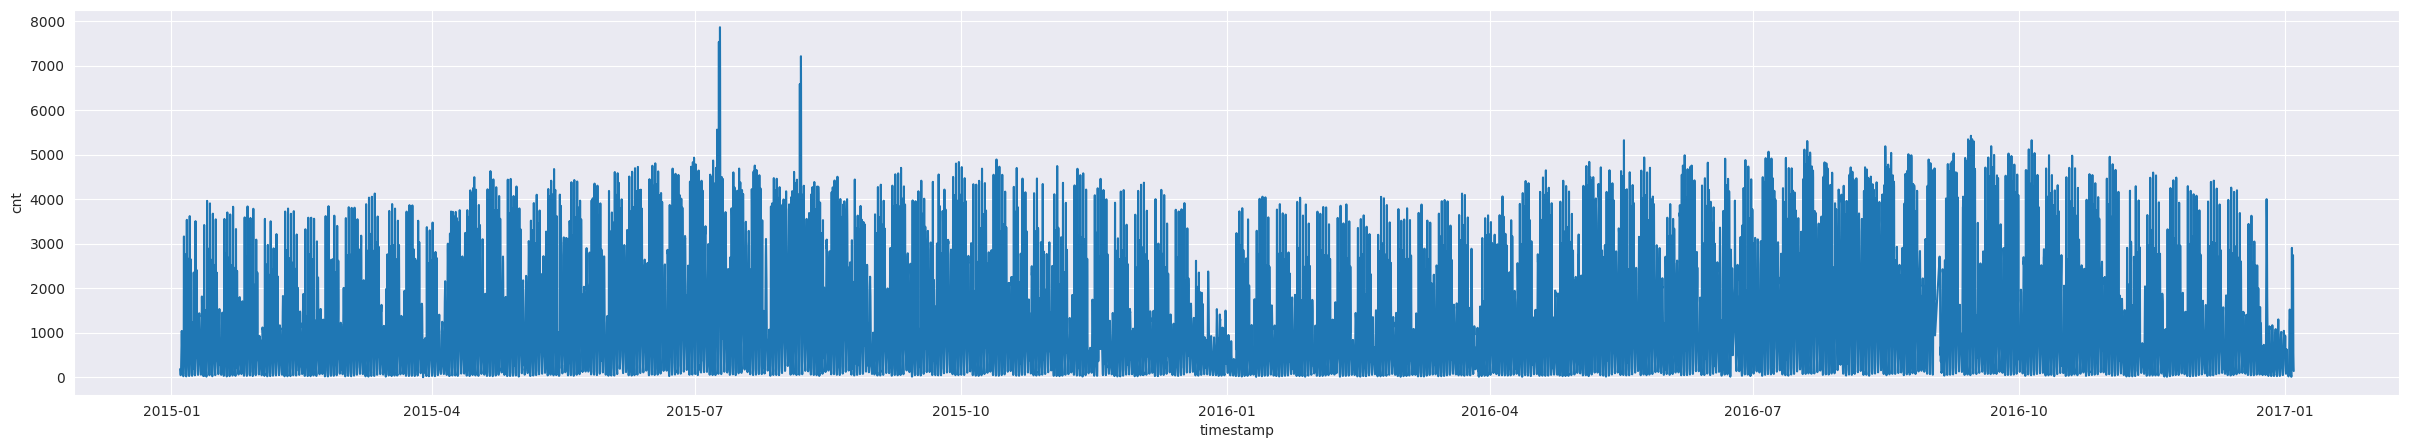

In [6]:
plt.figure(figsize=(30, 5))
sns.lineplot(x=df.index, y='cnt',data=df)

<Axes: xlabel='timestamp', ylabel='cnt'>

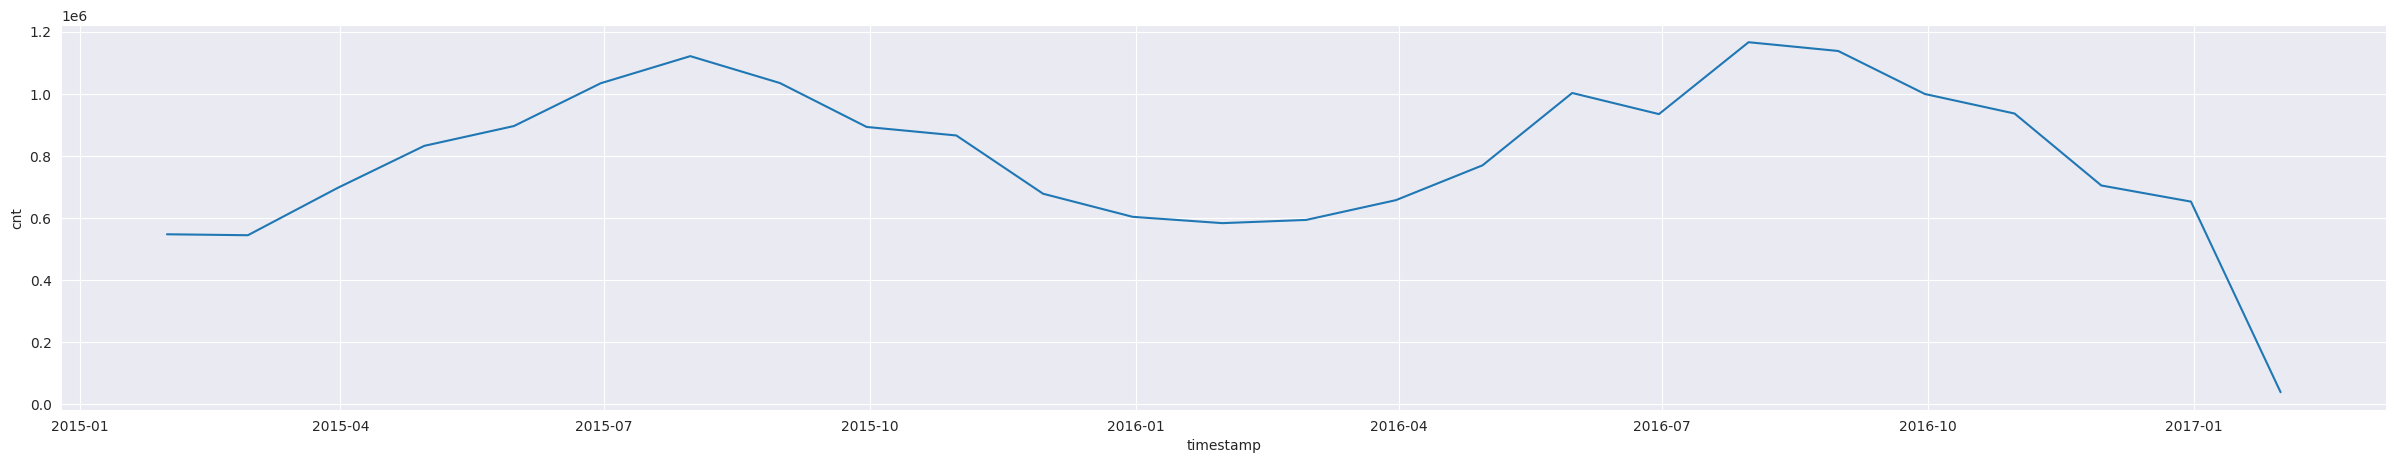

In [7]:
df_by_month = df.resample('M').sum()
plt.figure(figsize=(30,5))
sns.lineplot(x=df_by_month.index, y='cnt',data=df_by_month)

<Axes: xlabel='hour', ylabel='cnt'>

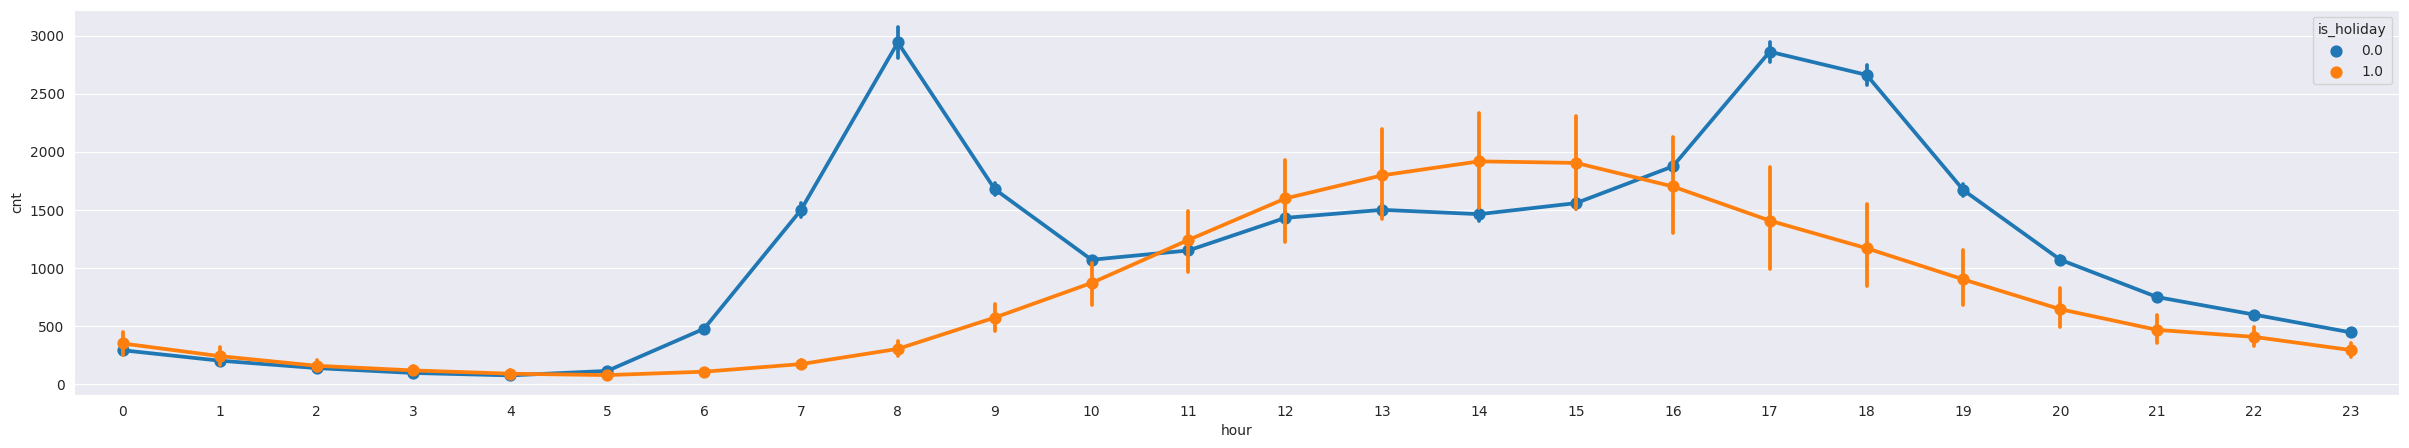

In [8]:
plt.figure(figsize=(30, 5))
sns.pointplot(x='hour', y='cnt',hue='is_holiday',data=df)

<Axes: xlabel='day_of_week', ylabel='cnt'>

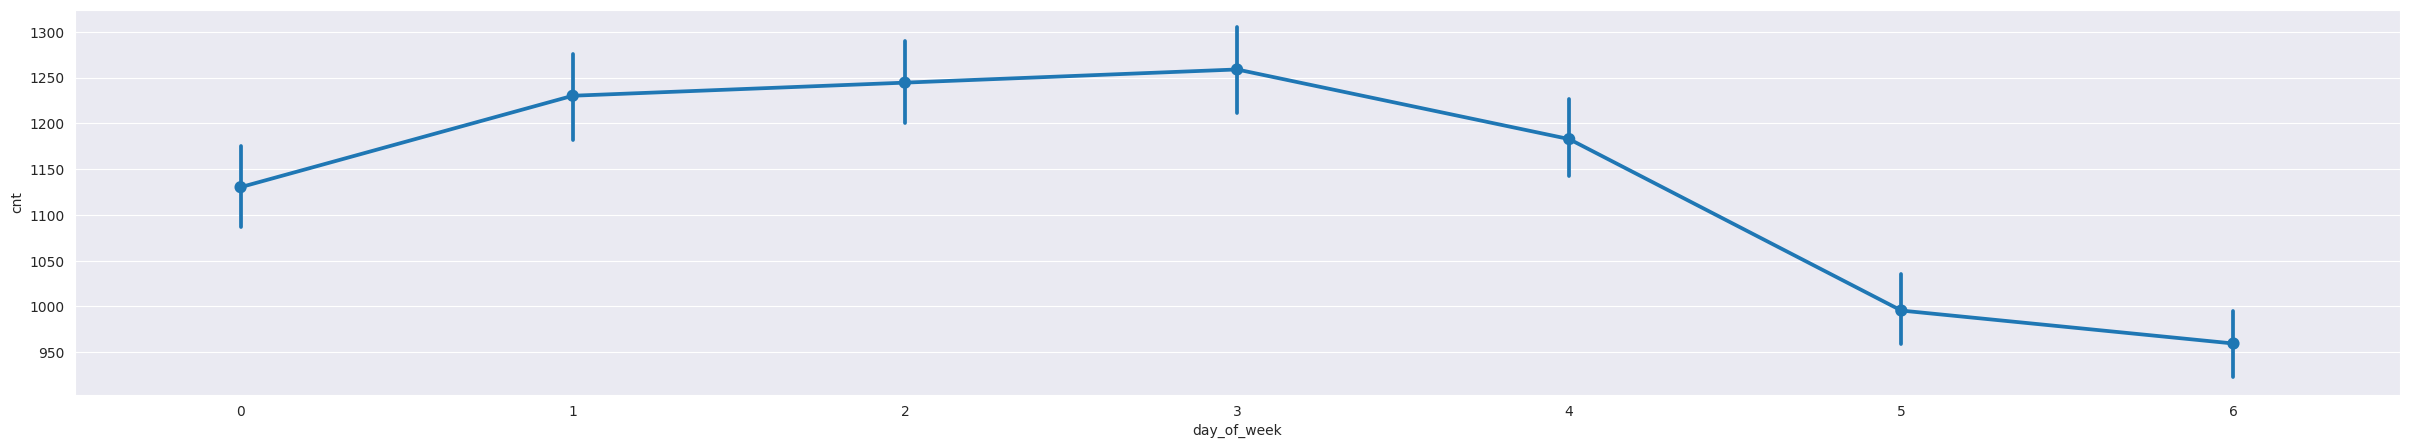

In [9]:
plt.figure(figsize=(30, 5))
sns.pointplot(x='day_of_week', y='cnt',data=df)

In [18]:
# Getting the size of the sets
training_set_size = int(len(df)*0.9)
test_set_size = len(df)-training_set_size

# Constructing the sets
train , test = df.iloc[0:training_set_size] , df.iloc[training_set_size:len(df)]
print("Shape of training set is", train.shape)
print("Shape of test set is",test.shape)

Shape of training set is (15672, 13)
Shape of test set is (1742, 13)


In [19]:
# import math
# # Get/Compute the number of rows to train the model on
# training_data_len = math.ceil(len(df) *.9) # taking 90% of data to train and 10% of data to test
# testing_data_len = len(df) - training_data_len

# time_steps = 24
# train, test = df.iloc[0:training_data_len], df.iloc[(training_data_len-time_steps):len(df)]
# print(df.shape, train.shape, test.shape)

In [20]:
from sklearn.preprocessing import RobustScaler

In [21]:
# Scale the all of the data from columns ['t1', 't2', 'hum', 'wind_speed']
train_trans = train[['t1', 't2', 'hum', 'wind_speed']].to_numpy()
test_trans = test[['t1', 't2', 'hum', 'wind_speed']].to_numpy()
Robust_scale = RobustScaler().fit(train_trans)
train.loc[:, ['t1', 't2', 'hum', 'wind_speed']]=Robust_scale.transform(train_trans)
test.loc[:, ['t1', 't2', 'hum', 'wind_speed']]=Robust_scale.transform(test_trans)

In [25]:
#Scale the all of the data from columns ['cnt']
Robust_scale = RobustScaler().fit(train[['cnt']])
train['cnt'] = Robust_scale.transform(train[['cnt']])
test['cnt'] = Robust_scale.transform(test[['cnt']])

/tmp/ipykernel_3834/1189700782.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cnt'] = Robust_scale.transform(train[['cnt']])
/tmp/ipykernel_3834/1189700782.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['cnt'] = Robust_scale.transform(test[['cnt']])


In [26]:
train.to_numpy()
test.to_numpy()

array([[-0.37052342, -0.1       ,  0.06666667, ...,  6.        ,
        23.        , 10.        ],
       [-0.07782369,  0.2       ,  0.2       , ...,  6.        ,
        23.        , 10.        ],
       [ 0.34573003,  0.4       ,  0.4       , ...,  6.        ,
        23.        , 10.        ],
       ...,
       [-0.35812672, -0.6       , -0.66666667, ...,  1.        ,
         3.        ,  1.        ],
       [-0.43595041, -0.6       , -0.66666667, ...,  1.        ,
         3.        ,  1.        ],
       [-0.49449036, -0.7       , -0.73333333, ...,  1.        ,
         3.        ,  1.        ]])

In [27]:
time_steps = 24
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(len(train) - time_steps):
    x_train.append(train.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    y_train.append(train.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

In [28]:
#Create the x_test and y_test data sets
x_test = []
y_test = df.loc[:,'cnt'].iloc[training_data_len:len(df)]

for i in range(len(test) - time_steps):
    x_test.append(test.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    #y_test.append(test.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_test and y_test to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

In [29]:
# [samples, time_steps, n_features]
# Using all 12 columns of data (take out the bike sharing amount column) to make prediction
print('Train data size:')
print(x_train.shape, y_train.shape)
print('Test data size:')
print(x_test.shape, y_test.shape)

Train data size:
(15648, 24, 12) (15648,)
Test data size:
(1718, 24, 12) (1741,)


In [30]:
#Build the LSTM network model
model = keras.Sequential()
model.add(keras.layers.Bidirectional(
    keras.layers.LSTM(units=50,input_shape=(x_train.shape[1], x_train.shape[2]))))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

2023-09-04 00:17:14.961119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-04 00:17:15.094059: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-09-04 00:17:15.094095: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-09-04 00:17:15.095760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

In [31]:
history = model.fit(x_train, y_train, epochs=5, batch_size=20, validation_split=0.15, shuffle=True)

Epoch 1/5
665/665 [==============================] - 12s 14ms/step - loss: 0.3176 - val_loss: 0.3100
Epoch 2/5
665/665 [==============================] - 9s 13ms/step - loss: 0.1540 - val_loss: 0.1148
Epoch 3/5
665/665 [==============================] - 9s 14ms/step - loss: 0.0825 - val_loss: 0.0962
Epoch 4/5
665/665 [==============================] - 10s 15ms/step - loss: 0.0652 - val_loss: 0.0768
Epoch 5/5
665/665 [==============================] - 9s 14ms/step - loss: 0.0578 - val_loss: 0.0857


In [32]:
y_pred = model.predict(x_test)
y_pred = Robust_scale.inverse_transform(y_pred)#Undo scaling
y_pred

54/54 [==============================] - 1s 5ms/step


array([[3056.8123 ],
       [1525.8268 ],
       [1075.7261 ],
       ...,
       [ 388.18726],
       [ 340.16663],
       [ 330.95074]], dtype=float32)

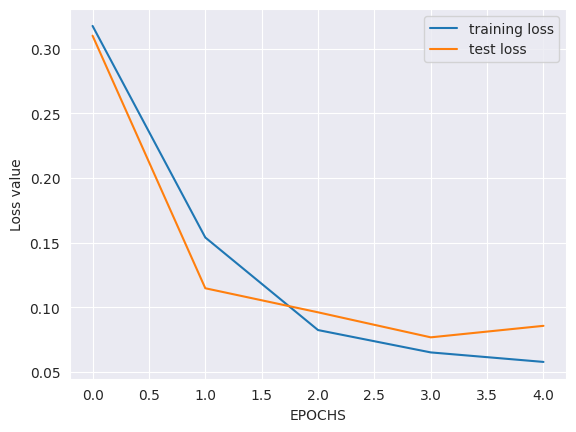

In [33]:
fig,ax = plt.subplots()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='test loss')
ax.set_xlabel('EPOCHS')
ax.set_ylabel('Loss value')
plt.legend();

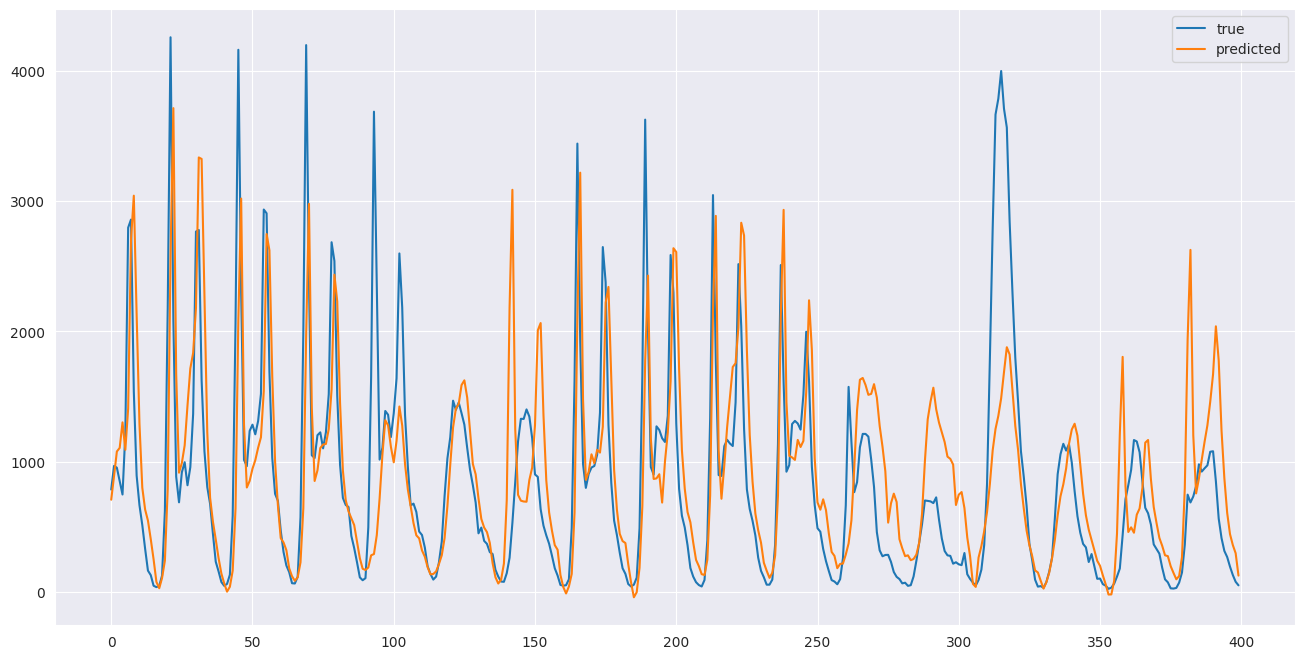

In [34]:
#Pcik some values to zoom in
plt.figure(figsize=(16, 8))
plt.plot(y_test[1200:1600], label='true')
plt.plot(y_pred[1200:1600], label='predicted')
plt.legend()